In [6]:
import json
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
import os
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [7]:
directories = os.listdir()
data_path = [dir for dir in directories if dir.startswith("data")][0]


Load modernity signatures and create dataframe


In [8]:
def extract_all_features(folder_path):
    vers_dict = defaultdict(list)
    files = [f for f in os.listdir(folder_path) if f.endswith('.json')]
    #print(f"Found {len(files)} JSON files in {folder_path}.")
    records = []
    for file in files:
        with open(os.path.join(folder_path, file), 'r') as f:
            json_file = json.load(f)
            
            repo_name = next(iter(json_file))  # Get the first key as repository name
            #print(f"Processing file: {file} for repository: {repo_name}")
            list_of_commits = next(iter(json_file.values()))
            #agregated_results = 
            for commit in list_of_commits:
                #print(f"Processing commit {list_of_commits.index(commit)+1} at date {commit['Date']}")
                row = {"Date": commit['Date'], 
                       "Repository": repo_name}
                
                
                results_per_version = commit['ResultsPerVersion']
                for version in results_per_version:
                    version_nr = version['Version']
                    values = version['Values']
                    if version_nr not in vers_dict.keys():
                        vers_dict[version_nr] = []
                    for key in values.keys():
                        if key not in vers_dict[version_nr]:
                            vers_dict[version_nr].append(key)
                        row[key] = values[key]
                        if key not in features_:
                            features_.append(key)
                    #total_usage = sum(values.values())
                    
                    #row[version['Version']] = total_usage
                    #print(f"Total usage in version {version_nr} is {total_usage}.")
                
                records.append(row)
                
    return records, vers_dict

version_colors = {
    "7.1": "tab:brown",
    "7.2": "tab:olive",
    "7.3": "tab:pink",
    "8": "tab:blue",
    "9": "tab:orange",
    "10": "tab:green",
    "11": "tab:red",
    "12": "tab:purple"
}
# versions_ = [ "7.1", "7.2", "7.3", "8", "9", "10", "11", "12"]
features_ =[]
df,vers_dict = extract_all_features(data_path)
df = pd.DataFrame(df)

df_binary,vers_dict = extract_all_features(data_path)
df_binary = pd.DataFrame(df)


df.to_csv("dataframe_language_features.csv", index=False)
# print(df.head(10))
df.to_csv("Test.csv", index=False)
df_binary.columns = df_binary.columns.astype(str).str.strip()
df_binary[features_] = (df_binary[features_]>0).astype(int)  # Convert to binary presence/absence
print(df_binary.head(10))

         Date Repository  async Main  Default expressions  \
0  20-03-2020    1Remote           0                    0   
1  28-03-2020    1Remote           0                    0   
2  12-04-2020    1Remote           0                    1   
3  20-04-2020    1Remote           0                    1   
4  04-05-2020    1Remote           0                    1   
5  07-05-2020    1Remote           0                    1   
6  14-05-2020    1Remote           0                    1   
7  20-05-2020    1Remote           0                    1   
8  15-06-2020    1Remote           0                    1   
9  01-07-2020    1Remote           0                    1   

   Inffered tuple element names  Pattern matching with generics  \
0                             0                               0   
1                             0                               0   
2                             0                               0   
3                             0                             

Similarity heatmap


In [ ]:


df_binary["Date"] = pd.to_datetime(df_binary["Date"], dayfirst=True)
df_binary["YearMonth"] = df_binary["Date"].dt.to_period("M")

df_monthly = df_binary.sort_values(by="Date").groupby(["Repository", "YearMonth"]).tail(1).reset_index(drop=True)


df_monthly = df_monthly.sort_values(by=["Repository","Date"]).reset_index(drop=True)

df_monthly["Date"]= pd.to_datetime(df_monthly["Date"], dayfirst=True) #Convert date to proper datetime

df_monthly["Padding"] = 0 #Add the padding as 0 to existent columns, so when I add the new columns they will be aligned

df_monthly = df_monthly.set_index(["Repository","YearMonth"])

all_months = pd.period_range(start = df_monthly.index.get_level_values("YearMonth").min(),
                             end = df_monthly.index.get_level_values("YearMonth").max(),
                             freq='M')

repos = df_monthly.index.get_level_values("Repository").unique()

full_index = pd.MultiIndex.from_product([repos, all_months], names=["Repository", "YearMonth"])
df_monthly = df_monthly.reindex(full_index)
df_monthly["Padding"] = df_monthly["Padding"].fillna(1)  # Fill NaN values with 0

df_monthly[features_] = df_monthly[features_].fillna(0)  # Fill NaN values with 0 for versions

df_monthly = df_monthly.reset_index().sort_values(by=["Repository", "YearMonth"]).reset_index(drop=True)

df_monthly.to_csv("monthly_results.csv", index=True)
df_monthly = df_monthly[df_monthly["YearMonth"] >= pd.Period("2019-01", freq="M")]

monthly_repo_counts = (
    df_monthly[df_monthly["Padding"] == 0]
    .groupby("YearMonth")["Repository"]
    .nunique()
    .reset_index(name="RepoCount")
)
monthly_repo_counts.to_csv("monthly_repo_counts.csv", index=False)
print(monthly_repo_counts)


real_data = df_monthly[df_monthly["Padding"] == 0]

heatmap_data = (
    real_data.groupby("YearMonth")[features_]
    .mean()
    .T
)
y_labels = heatmap_data.index.tolist()
ytick_colors = [version_colors[vers_dict.get(label, "8")] for label in y_labels]




   YearMonth  RepoCount
0    2019-01         59
1    2019-02         54
2    2019-03         56
3    2019-04         67
4    2019-05         52
..       ...        ...
72   2025-01         57
73   2025-02         57
74   2025-03         53
75   2025-04         56
76   2025-05         51

[77 rows x 2 columns]


NameError: name 'feature_to_version' is not defined

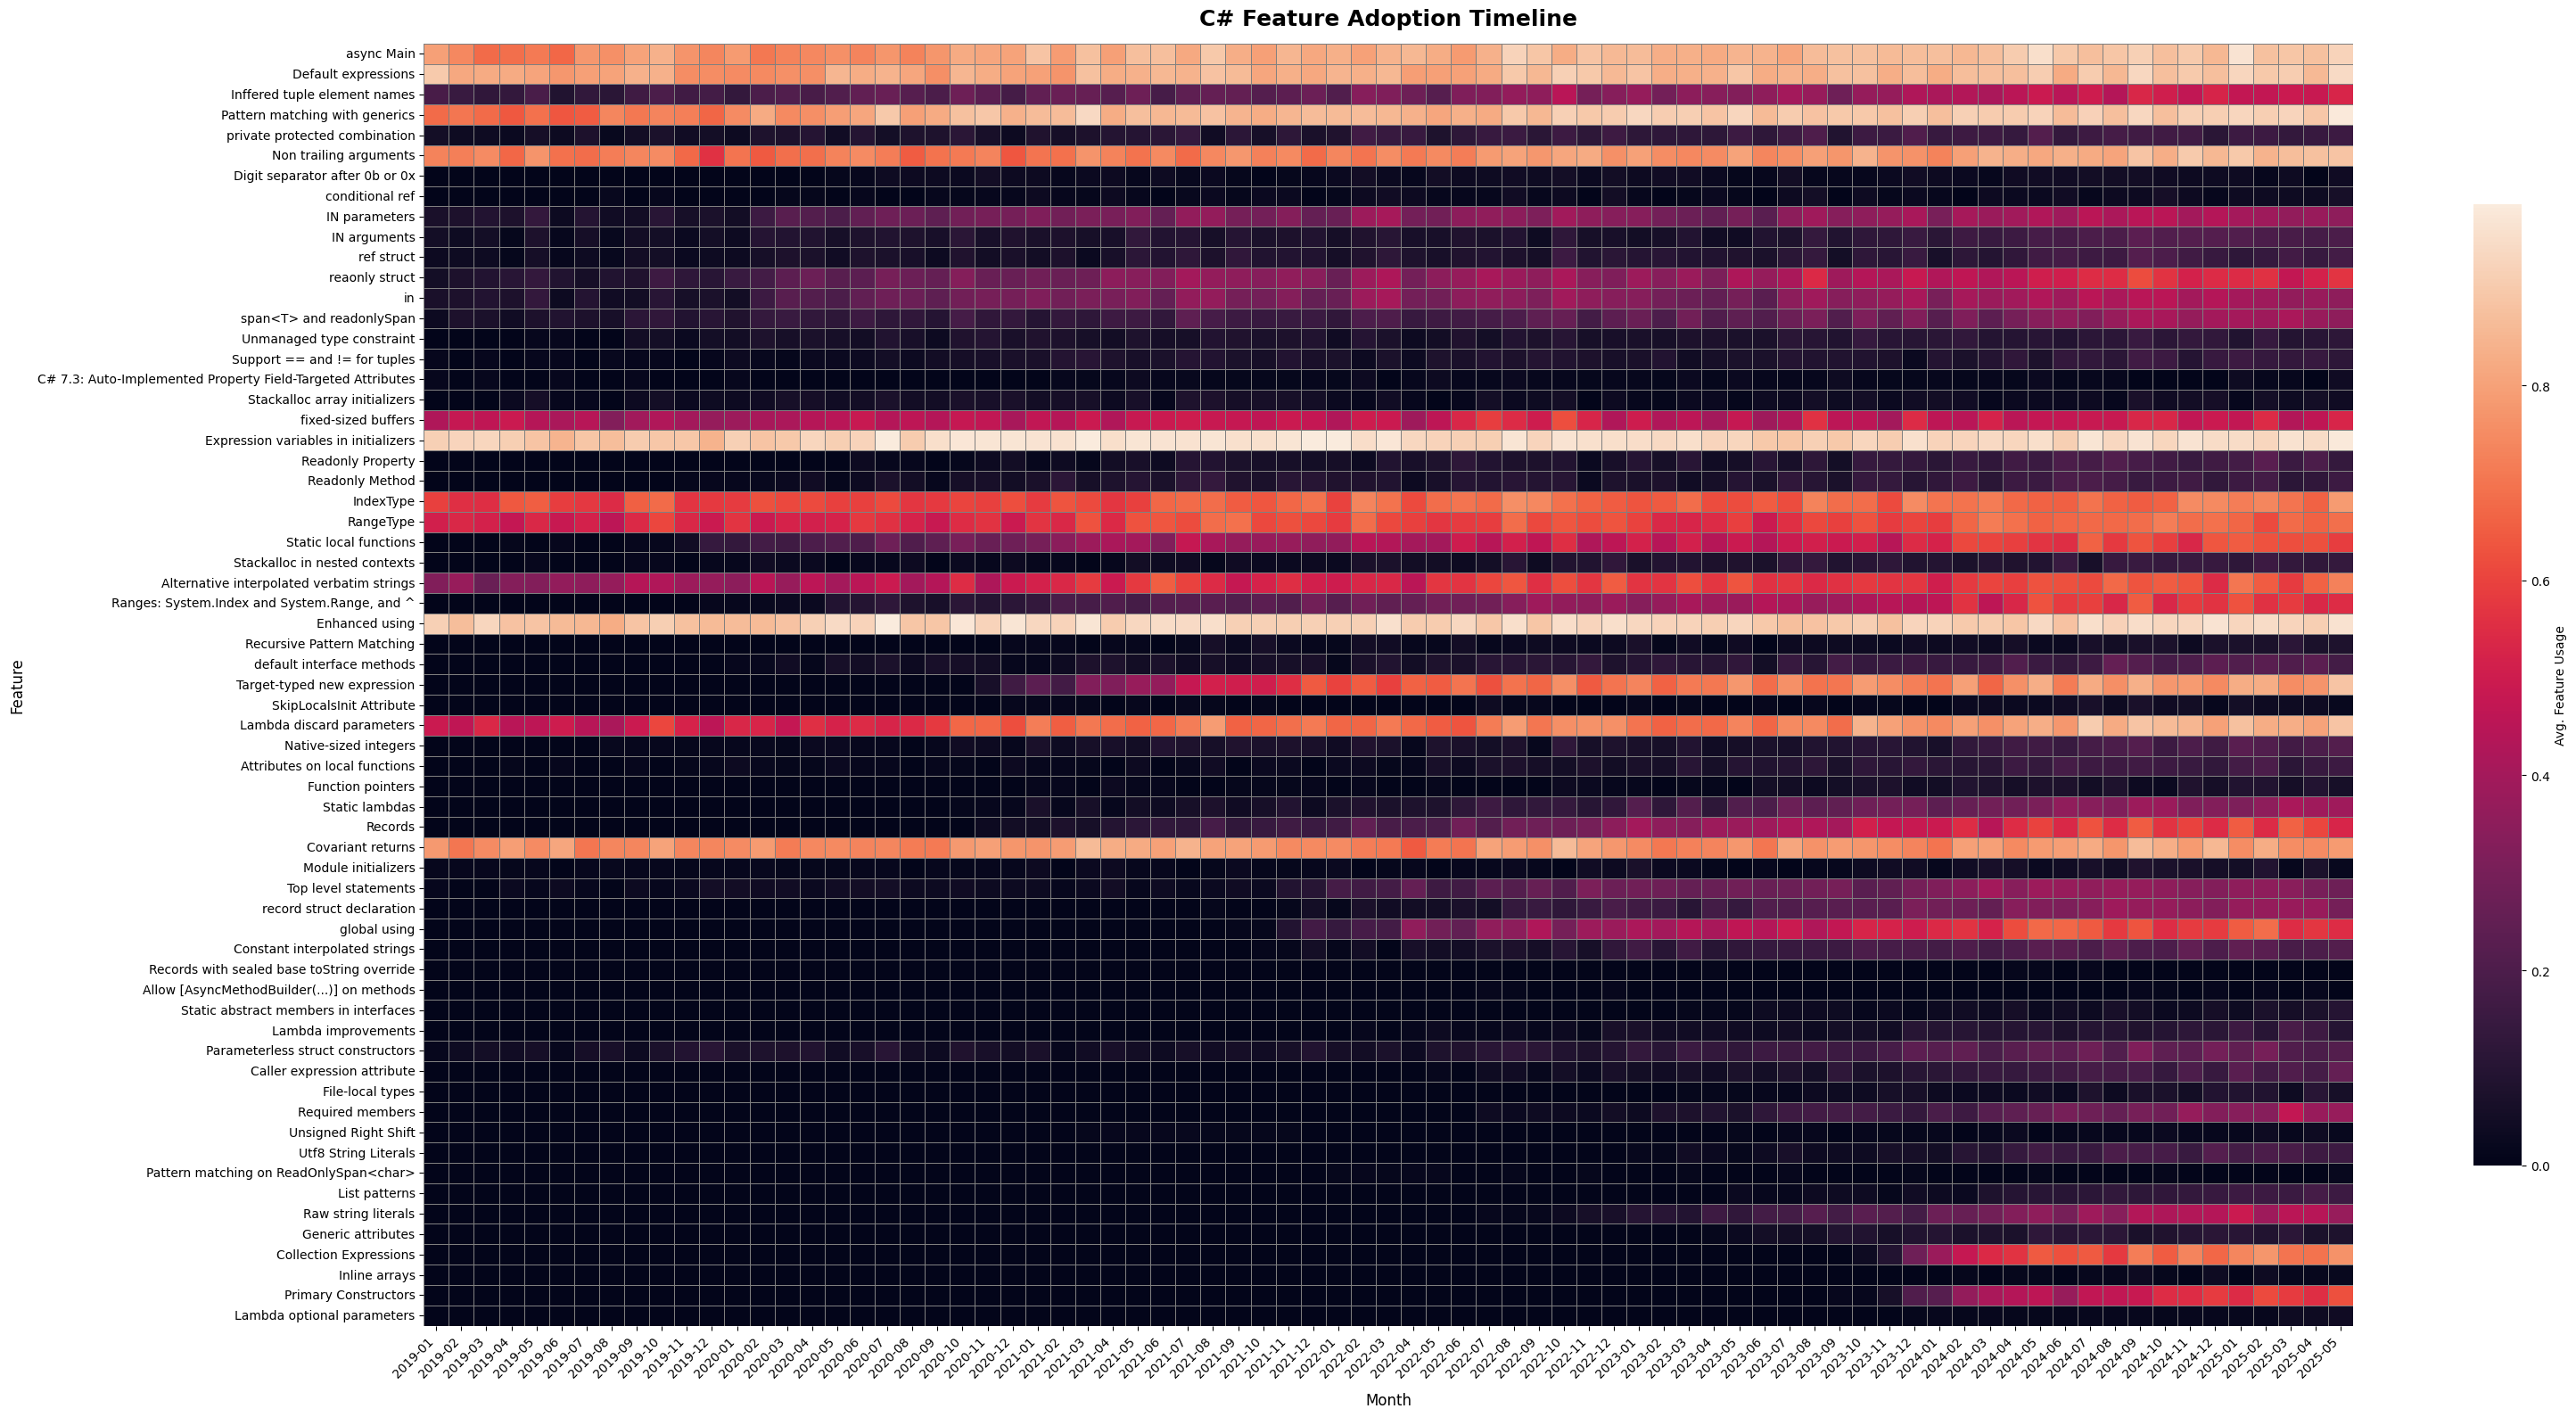

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(32, 16))

sns.heatmap(
    heatmap_data,
    cmap="rocket",               # 🔴 high-contrast dark-to-light red
    linewidths=0.6,
    linecolor="gray",
    cbar_kws={
        "shrink": 0.75,
        "label": "Avg. Feature Usage",
        "orientation": "vertical"
    },
    square=False,
    annot=False
)
for tick_label, color in zip(ax.get_yticklabels(), ytick_colors):
    tick_label.set_color(color)

plt.title("C# Feature Adoption Timeline", fontsize=18, fontweight='bold', pad=15)
plt.xlabel("Month", fontsize=12, labelpad=10)
plt.ylabel("Feature", fontsize=12, labelpad=10)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.grid(False)
plt.tight_layout()
plt.show()
